In [68]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [96]:
def parse_tb_logs(nb_folds, metrics_path, metrics_to_plot):
    values = defaultdict(list)

    for fold_nb in range(nb_folds):
        fold_string = f"fold_{fold_nb}"
        print(fold_string,  end = ' ')
        event_acc = EventAccumulator(join(metrics_path, fold_string))
        event_acc.Reload()
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                if tag == 'val_acc':
                    print(f"Max_acc: {max(vals):.3}", end=" ")
                if len(vals) < 3 or ('acc' in tag and max(vals) < 0.75):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list)
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"warning: {tag} not in logs")
                #values[tag].append([])
                pass
        print()
    return values

def interpolate_values(metrics_to_plot, values, tot_num_values=100, max_epochs=1000,
                      val_epochs_logged=False):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = val_epochs_logged and 'val' in metric_name
        max_epochs_real = values['val_epoch'] if val_cond else values[f'{metric_name}_step']
        print('max_epochs_real', max_epochs_real, val_epochs_logged)
        max_epochs_real = max(max(max_epochs_real)) 
        max_epochs = min(max_epochs, max_epochs_real)
        x = np.linspace(0, max_epochs, num=tot_num_values)
        temp_lists=[]
        if val_cond:
            metric_log_steps = values['val_epoch']
        else:
            metric_log_steps = values[f'{metric_name}_step']
            
        for steps, vals in zip(metric_log_steps, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label):
    for i, metric_name in enumerate(metrics_to_plot):
        epochs = interp_values_df[f'{metric_name}_interp_steps'] 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("epoch")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]), '--k', linewidth=1, alpha=0.1)
        
    return ax

def plot_agg_metrics(metrics_to_plot, metrics_paths, checkpoints, nb_fold, 
                     name: str=None, tot_num_values=200, max_epochs=1000, 
                     plot_legend=False, val_epochs_logged=False):
    rejected_ckpts=[]
    f,a = plt.subplots(len(metrics_to_plot),1)
    f.set_size_inches(10,14)
    f.tight_layout()
    plt.ylim(0,1.1)
    if not type(nb_fold)==list:
        nb_fold = [nb_fold]*len(checkpoints)
        
    for metrics_path, ckpt_name, n_fold in zip(metrics_paths, checkpoints, nb_fold):
        print(ckpt_name)
        metric_values = parse_tb_logs(n_fold, metrics_path, metrics_to_plot)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
        val_epochs_logged = 'val_epoch' in metric_values.keys()
        print(metric_values.keys())
        interp_values = interpolate_values(metrics_to_plot, metric_values, 
                                           tot_num_values=tot_num_values, max_epochs=max_epochs, 
                                           val_epochs_logged=val_epochs_logged)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][4]
        #print(ckpt_name[label_pos+1:])
        plot_metrics(metrics_to_plot, interp_values_df, a, label=str(ckpt_name[label_pos+1:]))
    if plot_legend:
        for ax in a:
            ax.legend()
        
    f.subplots_adjust(hspace=0.4)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
        
    return rejected_ckpts

In [85]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

metrics_to_plot = ['val_loss', 'val_acc', 'val_epoch']
nb_fold= 2


In [51]:
checkpoints_d3 = []
checkpoints_d4 = []
checkpoints_d5 = ['ckpt_27098065_0704_2133_synth_rand_b0_d5']

checkpoints_d6 = ['ckpt_27098636_0804_1208_synth_rand_b0_d6']

checkpoints_rand = ['ckpt_27096585_0704_1437_synth_rand_b0_d3',
                    'ckpt_27096594_0704_1539_synth_rand_b0_d4',
                    'ckpt_27098065_0704_2133_synth_rand_b0_d5',
                   'ckpt_27098636_0804_1208_synth_rand_b0_d6']

checkpoints_b1 = ['ckpt_27096592_0704_1527_synth_um_b1_d3',
              'ckpt_27096593_0704_1538_synth_um_b1_d4']

checkpoints_b10 = ['ckpt_27097384_0704_1712_synth_um_b10_d3',
              'ckpt_27097385_0704_1740_synth_um_b10_d4']

checkpoints_b100 = ['ckpt_27096591_0704_1527_synth_um_b100_d3',
                  'ckpt_27098061_0704_2056_synth_um_b100_d4']

checkpoints_b1000 = ['ckpt_27104195_1104_1116_synth_um_b1000_d4',
                    'ckpt_27103506_1104_1044_synth_um_b1000_d3']

checkpoints_lr = ['ckpt_27104194_1104_1115_synth_um_b1000_d4',
                 'ckpt_27104195_1104_1116_synth_um_b1000_d4']


In [52]:
checkpoints_list = [checkpoints_d4, checkpoints_d5, checkpoints_d6,
                    checkpoints_rand, checkpoints_b1, checkpoints_b10,
                    checkpoints_b100, checkpoints_b1000, checkpoints_lr]

checkpoints_names = ['checkpoints_d4', 'checkpoints_d5', 'checkpoints_d6',
                    'checkpoints_rand', 'checkpoints_b1', 'checkpoints_b10',
                    'checkpoints_b100', 'checkpoints_b1000', 'checkpoints_lr']


checkpoints_d4


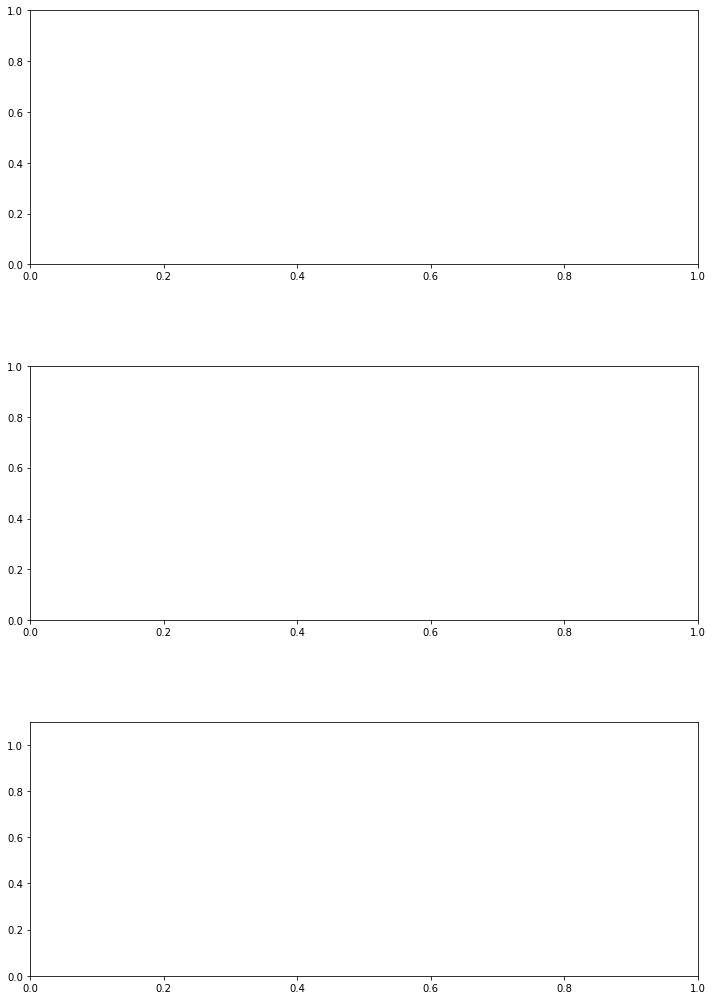

checkpoints_d5
ckpt_27098065_0704_2133_synth_rand_b0_d5
fold_0 

DirectoryDeletedError: Directory ../logs/ckpt_27098065_0704_2133_synth_rand_b0_d5/metrics_synth/fold_0 has been permanently deleted

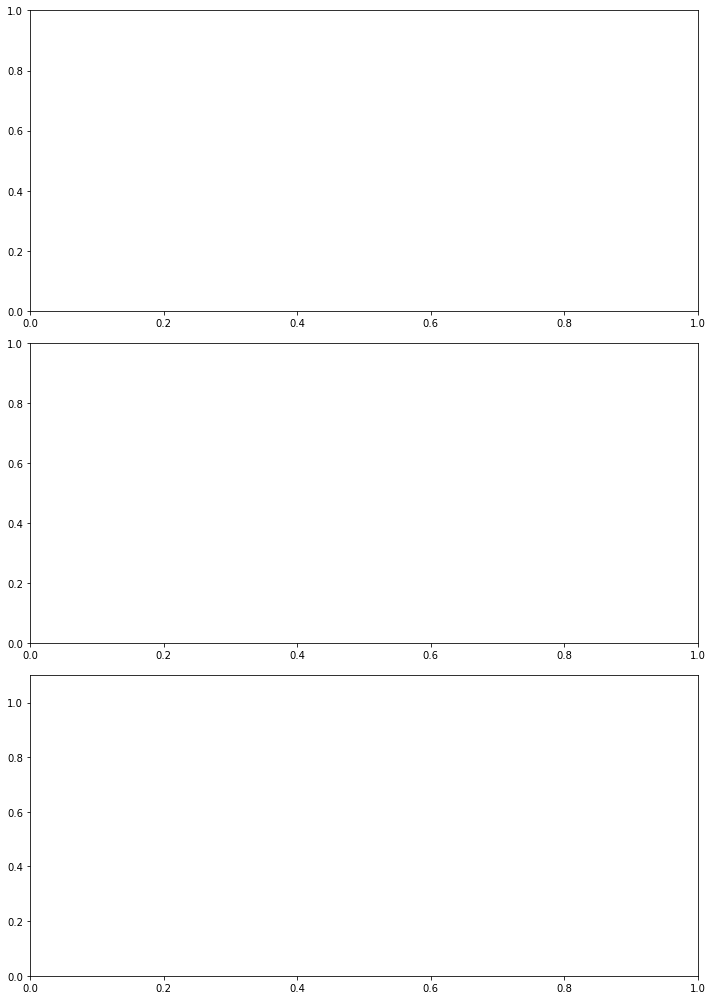

In [97]:
for checkpoints, ckpt_name in zip(checkpoints_list, checkpoints_names):
    print(f'{bcolors.OKBLUE}{ckpt_name}{bcolors.ENDC}')
    metrics_paths = [f"../logs/{ckpt}/metrics_synth/" for ckpt in checkpoints]
    plot_agg_metrics(metrics_to_plot, 
                     metrics_paths, checkpoints, nb_fold, 
                     name=ckpt_name, tot_num_values=300, max_epochs=1200)
    plt.show()

ckpt_27111823_1404_1422_synth_um_b1_d5
fold_0 val_loss 5, val_acc 5, Max_acc: 1.0 val_epoch 5, 
dict_keys(['val_loss', 'val_loss_step', 'fold_nb', 'val_acc', 'val_acc_step', 'val_epoch', 'val_epoch_step'])
max_epochs_real [[0.0, 1.0, 4.0, 6.0, 7.0]] True
max_epochs_real [[0.0, 1.0, 4.0, 6.0, 7.0]] True
max_epochs_real [[0.0, 1.0, 4.0, 6.0, 7.0]] True
ckpt_27111649_1404_1205_synth_um_b0_d6
fold_0 val_loss 107, val_acc 107, Max_acc: 0.819 warning: val_epoch not in logs

dict_keys(['val_loss', 'val_loss_step', 'fold_nb', 'val_acc', 'val_acc_step'])
max_epochs_real [[39, 56, 88, 120, 189, 230, 265, 325, 347, 370, 394, 441, 485, 527, 600, 646, 662, 689, 731, 773, 802, 830, 868, 918, 931, 944, 979, 1065, 1088, 1101, 1118, 1165, 1190, 1221, 1281, 1349, 1387, 1455, 1536, 1562, 1591, 1608, 1624, 1642, 1665, 1683, 1706, 1737, 1753, 1777, 1821, 1867, 1890, 1954, 1991, 2021, 2046, 2077, 2161, 2193, 2245, 2300, 2338, 2398, 2484, 2528, 2551, 2604, 2645, 2747, 2784, 2842, 2869, 2898, 2943, 2965, 2994

ValueError: max() arg is an empty sequence

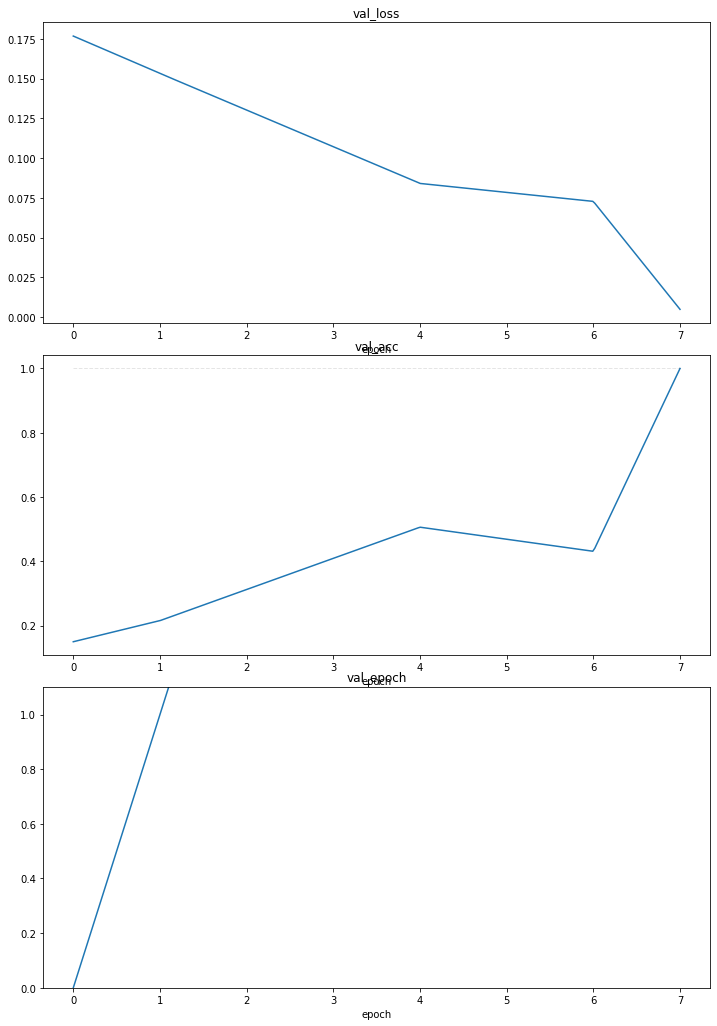

In [98]:
# loop over all files in directory

all_ckpt_dirs = os.listdir("../logs/")
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]


metrics_paths = [f"../logs/{ckpt}/metrics_synth/" for ckpt in all_ckpt_dirs]
rejected_ckpts = plot_agg_metrics(metrics_to_plot, metrics_paths, all_ckpt_dirs, nb_fold=1, 
                 name=checkpoints, tot_num_values=300, max_epochs=6500,
                plot_legend=False)
plt.show()